# A free-by-cyclic group (example 1)

In [1]:
import twisted_l2
from twisted_l2 import FreeByCyclic
import itertools

In [2]:
twisted_l2.load_hap()

true

In [3]:
f, phi, inv = FreeByCyclic.random_automorphism(3, length=20, seed=int(3219093496288654859), print_latex=True)
F = FreeGroup(f.ngens() + 1)

\eta_{2,1} \cdot \sigma_{1,3} \cdot \eta_{2,1} \cdot \eta_{3,2} \cdot \eta_{3,1}


The automorphism is $\varphi = \eta_{2,1} \cdot \sigma_{1,3} \cdot \eta_{2,1} \cdot \eta_{3,2} \cdot \eta_{3,1}$.

In [4]:
FreeByCyclic.random_automorphism.seed

3219093496288654859

In [5]:
print([phi(x) for x in f.gens()])
print([inv(x) for x in f.gens()])
print([phi(inv(x)) for x in f.gens()])

[x2, x1^-1*x0*x2, x2*x1^-1*x0*x2*x0^-1]
[x2^-1*x0*x1, x2^-1*x0*x1*x0*x1^-1, x0]
[x0, x1, x2]


## First method: compute a free $\mathbb Z[G]$-resolution of $\mathbb Z$

First, we make the free-by-cyclic group:

In [6]:
def relation(idx):
    """Returns a relation of the form t * g_i^-1 * t^-1 * phi(g_i) as a Tietze word."""
    n = f.ngens()
    return [n+1, -idx-1, -n-1] + list(phi(f.gen(idx)).Tietze())
    
G = F / [relation(i) for i in range(f.ngens())]
G

Finitely presented group < x0, x1, x2, x3 | x3*x0^-1*x3^-1*x2, x3*x1^-1*x3^-1*x1^-1*x0*x2, x3*x2^-1*x3^-1*x2*x1^-1*x0*x2*x0^-1 >

The stable letter is the last generator (`x3`).

In [7]:
G.abelian_invariants()

(0, 0)

A free $\mathbb Z[G]$-resolution of $\mathbb Z$ is the same thing as a chain complex for the universal cover of $K(G, 1)$:

In [8]:
res = twisted_l2.ComponentObjectWrapper(libgap.ResolutionAsphericalPresentation(G, 3))

In [9]:
[res.dimension(i) for i in range(4)]

[1, 4, 3, 0]

In [10]:
cc = twisted_l2.get_differentials(res)

In [20]:
cc[1]

[                                                                          -F[3]*F[0]^-1                                                                                       0                                                                    F[3]*F[0]^-1*F[3]^-1                                                                1 - F[3]*F[0]^-1*F[3]^-1]
[                                                           F[3]*F[1]^-1*F[3]^-1*F[1]^-1                                            -F[3]*F[1]^-1 - F[3]*F[1]^-1*F[3]^-1*F[1]^-1                                                       F[3]*F[1]^-1*F[3]^-1*F[1]^-1*F[0]                                                                1 - F[3]*F[1]^-1*F[3]^-1]
[F[3]*F[2]^-1*F[3]^-1*F[2]*F[1]^-1 - F[3]*F[2]^-1*F[3]^-1*F[2]*F[1]^-1*F[0]*F[2]*F[0]^-1                                                      -F[3]*F[2]^-1*F[3]^-1*F[2]*F[1]^-1           -F[3]*F[2]^-1 + F[3]*F[2]^-1*F[3]^-1 + F[3]*F[2]^-1*F[3]^-1*F[2]*F[1]^-1*F[0]                            

### How each class $\phi$ acts on the generators

In [11]:
[twisted_l2.gap_ZZ_to_int(twisted_l2.make_phi_from_coordinates(G, [1,0])(g)) for g in G.gens()]

[1, 1, 1, 0]

In [12]:
[twisted_l2.gap_ZZ_to_int(twisted_l2.make_phi_from_coordinates(G, [0,1])(g)) for g in G.gens()]

[0, 0, 0, 1]

If we identify `v` with $\phi$:

- $(1,0)$ has the stable letter in its kernel;
- $(0,1)$ is the canonical projection $G \twoheadrightarrow Z$.

Hence, $(0,1)$ is a fibered class for $G$.

In [16]:
twisted_l2.configs.LogOptions.LEVEL = twisted_l2.MINIMAL
twisted_l2.configs.LogOptions.PRECISION = 5

We compute the characteristic at $(0,1)$, $(1,1)$, $(1,0)$, $(-1,1)$,\
first using `exps = (3)` and `n = 4`, then `exps = (0,0,0,2)` and `n = 5`.

Heuristically, the rank computed in a finite quotient is a lower bound for the true Neumann rank.\
Hence, we take the ceiling of the rank (which is the same as taking the floor of each valuation).\
(This is a stronger heuristic than the one in `borromean.ipynb`.)

First, we define a little hack. The characteristic is a linear polynomial in the valuations $v_0, v_1, v_2, \dots$:

$$\chi^{(2)}(G; -) = - v_1 + 2v_2 -3v_3 + \dots + C.$$

Hence, if we have $(v_0, v_1, v_2, \dots)$ and $\chi^{(2)}(G; -)$, we can adjust the value to what it would have been, had we used the _floors_ of the valuations.

In [14]:
def characteristic_valuations_floor(char, valuations):
    return char + sum((-1)^j * j * (floor(val)-val) for j, val in enumerate(valuations))

In [17]:
%%time

vs = [(0,1),(1,1),(1,0),(-1,1)]

for v in vs:
    print(f"===== v = {v}, n = 4, 2-quotient =====")
    c1 = twisted_l2.characteristic(G, v, cc, 4, (3,))
    logs = twisted_l2.get_twisted_l2_logs()
    structures = {l.L.StructureDescription().sage() for l in logs}
    vals1 = [l.valuation for l in logs]
    print(f"Structure of L        : {structures}")
    
    print(f"===== v = {v}, n = 5, 7-quotient =====")
    c2 = twisted_l2.characteristic(G, v, cc, 5, (0,0,0,2))
    logs = twisted_l2.get_twisted_l2_logs()
    structures = {l.L.StructureDescription().sage() for l in logs}
    vals2 = [l.valuation for l in logs]
    print(f"Structure of L        : {structures}")
    
    valuations = (vals1, vals2)
    chars = (c1, c2)
    print("-"*40)
    print(f"Floors of valuations  : {[[floor(val) for val in vals] for vals in valuations]}")
    print(f"Characteristics       : {[characteristic_valuations_floor(char, vals) for char, vals in zip(chars, valuations)]}")
    print()

===== v = (0, 1), n = 4, 2-quotient =====
Degrees of Laplacians : [2.0, 8.0, 6.0]
Valuations            : [0.0, 0.0, 0.0]
Quotient sizes        : [128, 128, 128]
Characteristic        : -2.0
Structure of L        : {'C2 x ((C4 x C2) : C8)'}
===== v = (0, 1), n = 5, 7-quotient =====
Degrees of Laplacians : [2.0, 8.0, 6.0]
Valuations            : [0.0, 0.0, 0.0]
Quotient sizes        : [343, 343, 343]
Characteristic        : -2.0
Structure of L        : {'C49 x C7'}
----------------------------------------
Floors of valuations  : [[0, 0, 0], [0, 0, 0]]
Characteristics       : [-2, -2]

===== v = (1, 1), n = 4, 2-quotient =====
Degrees of Laplacians : [1.75, 7.125, 4.84375]
Valuations            : [0.125, 2.4375, 1.57812]
Quotient sizes        : [128, 128, 128]
Characteristic        : -1.28125
Structure of L        : {'C2 x ((C4 x C2) : C8)'}
===== v = (1, 1), n = 5, 7-quotient =====
Degrees of Laplacians : [2.0, 7.84257, 5.69679]
Valuations            : [0.0, 2.07872, 1.1516]
Quotient si

All values are consistent (the floors of the valuations stabilize at `n = 4`).

We can also plot the seminorm (that is, $-\chi^{(2)}(G; -)$):

In [ ]:
%%time

# Turn on automatic ceiling of rank / floor of valuation
twisted_l2.configs.FGARankOptions.CEILING = True
twisted_l2.configs.LogOptions.LEVEL = twisted_l2.SILENT

sn = twisted_l2.draw_seminorm(G, cc, 4, (3,), 1)

twisted_l2.configs.LogOptions.LEVEL = twisted_l2.MINIMAL
twisted_l2.configs.FGARankOptions.CEILING = False

In [ ]:
plots = []
for j in range(sn.nrows()):
    for k in range(sn.ncols()):
        x = (k - sn.ncols()//2)
        y = -(j - sn.nrows()//2)
        plots.append(line3d([(0,0,0), (x,y,-sn[j,k])]))
show(sum(plots))

## Second method: construct the presentation complex

In [24]:
fbc = FreeByCyclic(f, phi)

In [25]:
fl = twisted_l2.face_lattice_to_hap(fbc.make_fl())

In [26]:
cw = twisted_l2.cw_complex(fl)

In [27]:
chain_complex = twisted_l2.equivariant_cc(cw)

In [28]:
edge_to_word = twisted_l2.gap_member(chain_complex.group, "edgeToWord")

In [29]:
G = twisted_l2.get_fundamental_group(chain_complex)

In [30]:
cc = twisted_l2.get_differentials(chain_complex)

In [31]:
G

Finitely presented group < f1, f2, f3 | f1^-1*f3*f1*f3*f2^-1*f1^-1, f1^-1*f3*f2*f3^-1*f2^-1*f1*f2*f3^-1*f1*f2^-1*f1*f2*f3^-1*f1^-1 >

### Retrieving the original free-by-cyclic generators

In [32]:
# Find the indices of 1-cells corresponding to the stable letter and generators
st = [fbc.edge_backT()+1, fbc.edge_frontT()+1]
gens = [[fbc.edge_G(i, twisted_l2.free_by_cyclic.GEN_EDGE_BACK)+1,
         fbc.edge_G(i, twisted_l2.free_by_cyclic.GEN_EDGE_FRONT)+1] for i in range(fbc.N)]

In [33]:
# Get the corresponding elements of G
loops = gens + [st]
loopsG = [G((edge_to_word(e0) * edge_to_word(e1)^-1).UnderlyingElement().LetterRepAssocWord().sage()) for e0,e1 in loops]

In [34]:
print(f"Stable letter: {loopsG[-1]}")
print(f"Generators of F_{fbc.N}: {loopsG[:-1]}")

Stable letter: f1
Generators of F_3: [f1^-1*f3, f1^-1*f3*f2*f3^-1*f2^-1*f1*f2*f3^-1, f2*f3^-1]


In [35]:
[twisted_l2.gap_ZZ_to_int(twisted_l2.make_phi_from_coordinates(G, [0,1])(g)) for g in loopsG]

[1, 1, 1, 0]

In [36]:
[twisted_l2.gap_ZZ_to_int(twisted_l2.make_phi_from_coordinates(G, [1,1])(g)) for g in loopsG]

[0, 0, 0, 1]

Consider the basis $B = \{e_1 = (0,1), e_2 = (1,1)\}$ for `v`. If we identify `v` with $\phi$:

- $e_1$ has the stable letter in its kernel;
- $e_2$ is the canonical projection $G \twoheadrightarrow Z$.

Hence, $e_2$ is a fibered class for $G$.

In [37]:
def in_basis_B(t):
    return [t[1], t[0]+t[1]] 

### Doing the computation in this basis

In [41]:
twisted_l2.configs.LogOptions.LEVEL = twisted_l2.MINIMAL
twisted_l2.configs.LogOptions.PRECISION = 5

We compute the characteristic at $(0,1)$, $(1,1)$, $(1,0)$, $(-1,1)$,\
first using `exps = (3)` and `n = 4`, then `exps = (0,0,0,2)` and `n = 5`.

Heuristically, the rank computed in a finite quotient is a lower bound for the true Neumann rank.\
Hence, we take the ceiling of the rank (which is the same as taking the floor of each valuation).\
(This is a stronger heuristic than the one in `borromean.ipynb`.)

First, we define a little hack. The characteristic is a linear polynomial in the valuations $v_0, v_1, v_2, \dots$:

$$\chi^{(2)}(G; -) = - v_1 + 2v_2 -3v_3 + \dots + C.$$

Hence, if we have $(v_0, v_1, v_2, \dots)$ and $\chi^{(2)}(G; -)$, we can adjust the value to what it would have been, had we used the _floors_ of the valuations.

In [39]:
def characteristic_valuations_floor(char, valuations):
    return char + sum((-1)^j * j * (floor(val)-val) for j, val in enumerate(valuations))

In [43]:
%%time

vs = [(0,1),(1,1),(1,0),(-1,1)]

for v in vs:
    print(f"===== v = {v}, n = 4, 2-quotient =====")
    c1 = twisted_l2.characteristic(G, in_basis_B(v), cc, 4, (3,))
    logs = twisted_l2.get_twisted_l2_logs()
    structures = {l.L.StructureDescription().sage() for l in logs}
    vals1 = [l.valuation for l in logs]
    print(f"Structure of L        : {structures}")
    
    print(f"===== v = {v}, n = 5, 7-quotient =====")
    c2 = twisted_l2.characteristic(G, in_basis_B(v), cc, 5, (0,0,0,2))
    logs = twisted_l2.get_twisted_l2_logs()
    structures = {l.L.StructureDescription().sage() for l in logs}
    vals2 = [l.valuation for l in logs]
    print(f"Structure of L        : {structures}")
    
    valuations = (vals1, vals2)
    chars = (c1, c2)
    print("-"*40)
    print(f"Floors of valuations  : {[[floor(val) for val in vals] for vals in valuations]}")
    print(f"Characteristics       : {[characteristic_valuations_floor(char, vals) for char, vals in zip(chars, valuations)]}")
    print()

===== v = (0, 1), n = 4, 2-quotient =====
Degrees of Laplacians : [2.0, 8.0, 6.0]
Valuations            : [0.0, 1.0, 1.0]
Quotient sizes        : [128, 128, 128]
Characteristic        : -2.0
Structure of L        : {'C2 x ((C4 x C2) : C8)'}
===== v = (0, 1), n = 5, 7-quotient =====
Degrees of Laplacians : [2.0, 8.0, 6.0]
Valuations            : [0.0, 1.0, 1.0]
Quotient sizes        : [343, 343, 343]
Characteristic        : -2.0
Structure of L        : {'C49 x C7'}
----------------------------------------
Floors of valuations  : [[0, 1, 1], [0, 1, 1]]
Characteristics       : [-2, -2]

===== v = (1, 1), n = 4, 2-quotient =====
Degrees of Laplacians : [6.0, 15.0625, 9.03125]
Valuations            : [0.0, 1.46875, 1.48438]
Quotient sizes        : [128, 128, 128]
Characteristic        : -1.5
Structure of L        : {'C2 x ((C4 x C2) : C8)'}
===== v = (1, 1), n = 5, 7-quotient =====
Degrees of Laplacians : [6.0, 16.0, 10.0]
Valuations            : [0.0, 1.0, 1.0]
Quotient sizes        : [343

All values are consistent (the floors of the valuations stabilize at `n = 4`).

## Conclusion

Summary of results:

|  v   | $\chi^{(2)}(G; \phi)$ |
|:---: | ---:|
|(0, 1)|  -2 |
|(1, 1)|  -2 |
|(1, 0)|  -2 |
|(-1,1)|  -2 |

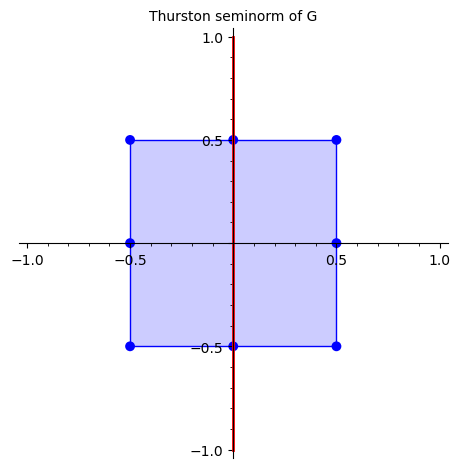

In [6]:
boundary = [(1/2,0),(1/2,1/2),(0,1/2),(-1/2,1/2)]
boundary = boundary + [(-a,-b) for a,b in boundary]

show(
    list_plot(boundary,
               aspect_ratio=1, size=50, xmin = -1, xmax = 1, ymin = -1, ymax = 1,
               title = "Thurston seminorm of G")
    + polygon(boundary + boundary[:1], alpha=0.2)
    + polygon(boundary + boundary[:1], fill=False)
    + line([(0,-1), (0,1)], color="red", thickness=2)
)

Both methods give $-2$ as the characteristic of the fibered class $(0,1)$ (in red) corresponding to $G \twoheadrightarrow \mathbb Z$.\
This is the _fiber Euler characteristic_, as $\chi(F_3) = -2$.